### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

import pickle
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

### Data Understanding

In [2]:
path = "/content/drive/MyDrive/Colab Notebooks/Assignment/Gembo/dataset.csv"

In [3]:
data = pd.read_csv(path)

In [4]:
data.head()

,DATE,SALES
0,9/30/18,39
1,10/1/18,25
2,10/2/18,48
3,10/3/18,32
4,10/4/18,87


In [5]:
data.columns = ['date', 'sales']
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [6]:
data.head()

,sales
date,
2018-09-30,39
2018-10-01,25
2018-10-02,48
2018-10-03,32
2018-10-04,87


In [7]:
data.tail()

,sales
date,
2019-03-21,32
2019-03-22,11
2019-03-23,22
2019-03-24,29
2019-03-25,14


### EDA

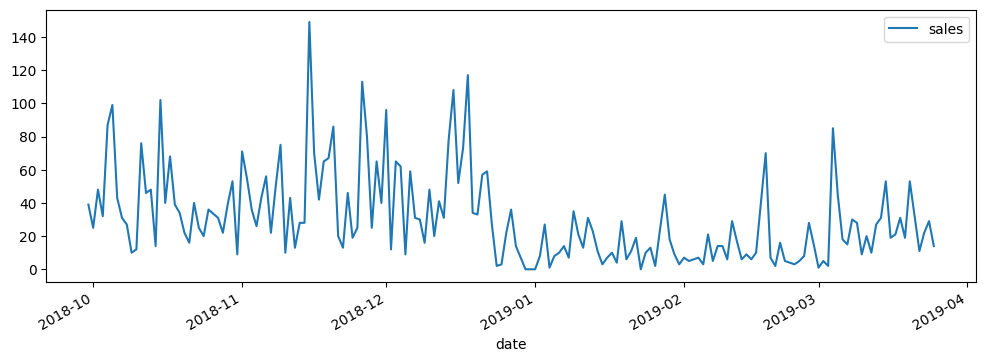

In [8]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.show(block=False)

In [9]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis. Data has no unit root and is non-stationary")


In [10]:
adfuller_test(data['sales'])

ADF Test Statistic : -3.7402398092017046
p-value : 0.0035814589654490072
#Lags Used : 3
Number of Observations Used : 169
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


### Train-Test

In [11]:
train_len = 140
train = data[0:train_len]
test = data[train_len:]

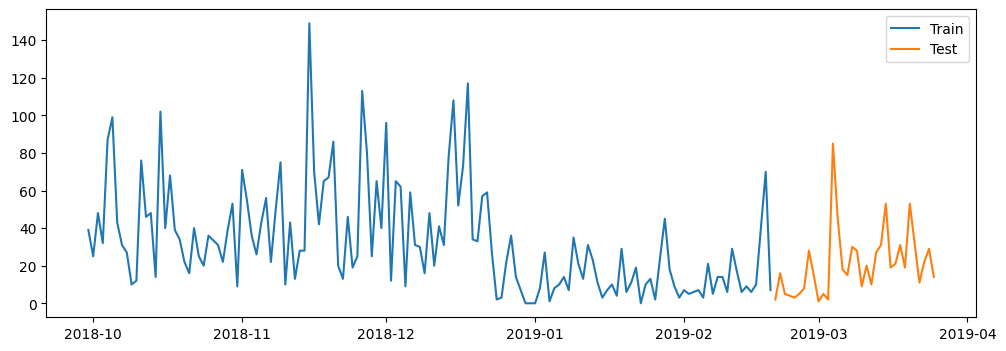

In [12]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.legend(loc='best')
plt.show()

### Feature Creation

In [13]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    return df

In [14]:
data = create_features(data)

In [15]:
data.head()

,sales,month,year,dayofmonth,dayofweek
date,,,,,
2018-09-30,39,9,2018,30,6
2018-10-01,25,10,2018,1,0
2018-10-02,48,10,2018,2,1
2018-10-03,32,10,2018,3,2
2018-10-04,87,10,2018,4,3


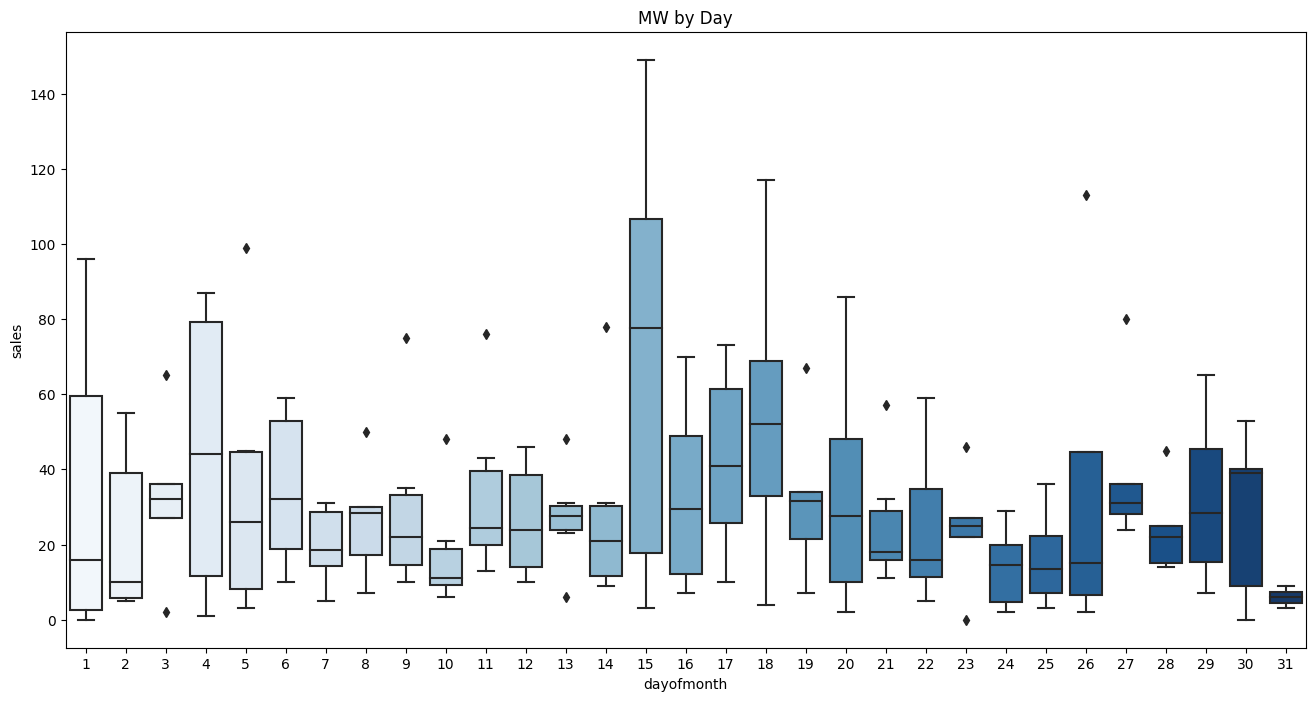

In [16]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=data, x='dayofmonth', y='sales', palette='Blues')
ax.set_title('MW by Day')
plt.show()

### Model

In [17]:
data.columns

Index(['sales', 'month', 'year', 'dayofmonth', 'dayofweek'], dtype='object')

In [18]:
train = create_features(train)
test = create_features(test)

FEATURES = ['month', 'year', 'dayofmonth', 'dayofweek']
TARGET = 'sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

#### Linear regression

In [19]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

LinearRegression()

In [20]:
test['prediction'] = lr_reg.predict(X_test)
lr_score = np.sqrt(mean_squared_error(test['sales'], test['prediction']))
print(f'RMSE Score on Test set: {lr_score:0.2f}')

RMSE Score on Test set: 18.02


In [21]:
# data1 = data.merge(test[['prediction']], how='left', left_index=True, right_index=True)
# ax = data1[['sales']].plot(figsize=(15, 5))
# data1['prediction'].plot(ax=ax, style='-')
# plt.legend(['Truth Data', 'Predictions'])
# ax.set_title('Raw Dat and Prediction')
# plt.show()

#### XGB

In [22]:
reg = xgb.XGBRegressor(
    n_estimators=500, min_child_weight=1, max_depth=4, learning_rate=0.02)

reg.fit(X_train, y_train, verbose=1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [23]:
test['prediction'] = reg.predict(X_test)

xgb_score = np.sqrt(mean_squared_error(test['sales'], test['prediction']))
print(f'RMSE Score on Test set: {xgb_score:0.2f}')

RMSE Score on Test set: 23.63


#### ARIMA

In [24]:
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

# 1,1,1 ARIMA Model
model = ARIMA(train.sales, order=(1,1,12))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
# test
predict_test = model_fit.predict(start=len(train)+1, end=len(data))
arima_score = np.sqrt(mean_squared_error(test['sales'], predict_test))
print(f'RMSE Score on Test set: {arima_score:0.2f}')

RMSE Score on Test set: 18.62


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [36]:
# pd.DataFrame(test['sales'].values, predict_test)

### Model results

In [26]:
models_result = {}
models_result['Linear Regression'] = lr_score
models_result['XGB Regression'] = xgb_score
models_result['ARIMA'] = arima_score

In [27]:
models_result = pd.DataFrame.from_dict(models_result.items())
models_result.columns = ['Model', 'RMSE']
models_result

,Model,RMSE
0,Linear Regression,18.016592
1,XGB Regression,23.629301
2,ARIMA,18.616746


- RMSE for models

In [28]:
filename = 'finalized_model.sav'
pickle.dump(lr_reg, open(filename, 'wb'))

## Predict

In [29]:
def get_date_list(n):
  date_str = '03-25-2019'
  date_object = datetime.strptime(date_str, '%m-%d-%Y').date()
  date_list = [date_object + timedelta(days=(i+1)) for i in range(n)]
  df = pd.DataFrame(date_list)
  df.columns = ['date']
  return df

def create_features_pred(df):
    """
    Create time series features based on time series index.
    """

    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    df = df.copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    return df

def model_predict(date_list):

  model = pickle.load(open('finalized_model.sav', 'rb'))

  date_list['sales'] = model.predict(date_list[['month', 'year', 'dayofmonth', 'dayofweek']])
  date_list = date_list.reset_index()

  return date_list[['date', 'sales']]


In [30]:
date_list = get_date_list(8)
date_list = create_features_pred(date_list)
output = model_predict(date_list)
output

,date,sales
0,2019-03-26,15.293161
1,2019-03-27,13.462099
2,2019-03-28,11.631037
3,2019-03-29,9.799976
4,2019-03-30,7.968914
5,2019-03-31,6.137852
6,2019-04-01,24.316068
7,2019-04-02,22.485006


## END